**1. Introduction**

> a) Credits

> The code for this model is based on a training example from tensorflow/keras website. Only minor modifications have been made. The dataset is from Kaggle at https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts, and data collection code is from GitHub at https://github.com/soumik12345/multi-label-text-classification/blob/master/beam_arxiv_scrape.ipynb.

> b) Objective

> Paper submission systems (CMT, OpenReview, etc.) require the users to upload paper titles and paper abstracts and then specify the subject areas that best describe them. The original motivation for this project was to automate the categorization process for future conferences, and to save the time and money spent standardizing manual entries. This requires multi-label classification.

> c) Use cases

> Multi-label classification of text has many applications in business. Examples include: 1) sentiment analysis on phone recordings, emails, reviews, social media posts, marketing copy, etc., and 2) segmentation of customers, influencers, publications, conference submissions, etc. Multi-label seems more appropriate than binary for real-world situations where things are rarely black or white. This type of classification is also built into many vendor tools.

> d) Deprecation

> The following code is an older approach to text classification. Tf-idf or term frequency–inverse document frequency is utilized here. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word. Since tf-idf, Word2Vec, LSTM and transformer models have been introduced with excellent results. Transformer models in particular should be considered state of the art today.

> e) Lessons

> The project provides an opportunity to learn about: 1) multi-label classification, 2) multi-label binarization, 3) tf.keras.layers.StringLookup() layer, 4) tf.data.AUTOTUNE function, 5) tf.data.Dataset objects and 6) tf.keras.layers.TextVectorization layer.

**2. Setup**

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**3. Pre-process Data**

> a) Download the data

In [2]:
arxiv_data = pd.read_csv(
                          "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)

> b) Explore data

> Text features are present in the summaries column and their corresponding labels are in terms column. There are multiple categories (terms) associated with each entry, i.e. 'cs.CV', 'cs.AI', and 'cs.LG'.

In [3]:
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [4]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


> The .duplicated() method is applied to the "titles" column of the pandas dataframe. The first occurrence of a duplicated item will not be counted, but all additional occurrences will be counted. The default code is: DataFrame.duplicated(subset=None, keep='first')[source]. Returns boolean Series denoting duplicate rows. The "keep" argument represents: {‘first’, ‘last’, False}, default ‘first’. Determines which duplicates (if any) to mark. first: Mark duplicates as True except for the first occurrence. last: Mark duplicates as True except for the last occurrence. False: Mark all duplicates as True.

In [5]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [6]:
deduped_data = arxiv_data[~arxiv_data["titles"].duplicated()] #was arxiv_data
print(f"There are {len(deduped_data)} rows that don't have duplicate titles.")

There are 38972 rows that don't have duplicate titles.


> The .value_counts() method counts the number of times a unique value occurs. The default definition is Series.value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True). The resulting object will be in descending order so that the first element is the most frequently-occurring element. Excludes NA values by default.

In [7]:
print(f'The number of groupings of terms that only occur once is {sum(deduped_data["terms"].value_counts() == 1)}.')

The number of groupings of terms that only occur once is 2321.


In [8]:
print(f'The number of groupings of terms that occur more than 10 times is {sum(deduped_data["terms"].value_counts() > 10)}.')

The number of groupings of terms that occur more than 10 times is 176.


In [9]:
print(f'The average of the number of times a grouping of terms occurs is {round(deduped_data["terms"].value_counts().mean(), 2)}.')

The average of the number of times a grouping of terms occurs is 12.34.


In [10]:
print(f'The maximum number of times a grouping of terms occurs is {round(deduped_data["terms"].value_counts().max(), 2)}.')

The maximum number of times a grouping of terms occurs is 12747.


> The default definition of the .nunique() method is DataFrame.nunique(axis=0, dropna=True). Counts number of distinct elements in specified axis. Returns a Series with number of distinct elements. Can ignore NaN values.

In [11]:
print(f'The number of unique groupings of terms is {deduped_data["terms"].nunique()}.')

The number of unique groupings of terms is 3157.


> c) Filter the data

> First step is to dedupe our actual data before we go further.

In [12]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()] 

> Next the data is filtered for data points with groupings of terms that only occur once. These data points will be dropped from the dataset.

In [13]:
arxiv_data = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)

> The dataset now includes 3 columns and 36,651 rows.

In [14]:
arxiv_data.shape

(36651, 3)

> d) Convert the string labels to lists of strings

> The initial labels are represented as raw strings. Below they are changed to List[str] for a more compact representation. 5 examples are shown.

> Note: ".values" converts items to a numpy array. It is recommended that programmer use DataFrame.to_numpy() instead.

In [15]:
arxiv_data["terms"] = arxiv_data["terms"].apply(lambda x: literal_eval(x))

In [16]:
arxiv_data["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

> e) Create train, validation & test splits of data

> Next we split the test data into validation and test groups using the .sample() and .drop() methods. We now have "train_df", "val_df" and "test_df" dataframes.

> From scikit learn library, sklearn.model_selection.train_test_split is used to break the data into splits. The default configuration is: sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None). However, below we stratify the data using the terms column. The dataset has a class imbalance problem. So, to have a fair evaluation result, we need to ensure the datasets are sampled with stratification.

In [17]:
test_split = 0.1
train_df, test_df = train_test_split(
    arxiv_data,
    test_size=test_split,
    stratify=arxiv_data["terms"].values,
)

In [18]:
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

In [19]:
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


> f) Multi-label binarization

> Multilabel binarizer allows you to encode multiple labels per instance.

> The "terms" data is converted to ragged tensors. Ragged tensors are the TensorFlow equivalent of nested variable-length lists. They make it easy to store and process data with non-uniform shapes. The tf.ragged.constant() function constructs a constant RaggedTensor from a nested Python list. The default definition is tf.ragged.constant(pylist, dtype=None, ragged_rank=None, inner_shape=None, name=None, row_splits_dtype=tf.dtypes.int64). Any nested element that is not a list, tuple or np.ndarray must be a scalar value compatible with dtype. The function returns a tensor.

In [20]:
terms = tf.ragged.constant(train_df["terms"].values)

In [21]:
terms[:5]

<tf.RaggedTensor [[b'cs.CV', b'cs.LG', b'cs.NE'], [b'cs.CV'], [b'cs.CV'],
 [b'cs.LG', b'cs.SY', b'eess.SY'], [b'cs.CV']]>

> tf.keras.layers.StringLookup is a preprocessing layer which maps string features to integer indices. The default command is tf.keras.layers.StringLookup(max_tokens=None, num_oov_indices=1, mask_token=None, oov_token='[UNK]', vocabulary=None, idf_weights=None, encoding=None, invert=False, output_mode='int', sparse=False, pad_to_max_tokens=False, **kwargs). The "multi_hot" argument encodes each sample in the input "terms" column into a single array the same size as the vocabulary, containing a 1 for each vocabulary term present in the sample. It treats the last dimension as the sample dimension. If input shape is (..., sample_length), output shape will be (..., num_tokens).

In [22]:
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")

In [23]:
type(lookup)

keras.layers.preprocessing.string_lookup.StringLookup

> Some preprocessing layers have an internal state that can be computed based on a sample of the training data. The list of stateful preprocessing layers is: 
1) TextVectorization: holds a mapping between string tokens and integer indices, 2) StringLookup and IntegerLookup: hold a mapping between input values and integer indices, 3) Normalization: holds the mean and standard deviation of the features, and 4) Discretization: holds information about value bucket boundaries. Crucially, these layers are non-trainable. Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data. You set the state of a preprocessing layer by exposing it to training data, via the adapt() method.

In [24]:
lookup.adapt(terms)

> Next, the vocabulary is established using the .get_vocabulary() function. This function returns the vocabulary of the layer.

In [25]:
vocab = lookup.get_vocabulary()

In [26]:
print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.NI', 'cs.SE', 'cs.CG', 'stat.CO', 'I.2.6', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cs.PL', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', '68T05', 'quant-ph', 'physics.data-an', 'cs.CC', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'econ.EM', 'q-bio.GN', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', '68T10', 'physics.optics', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '

> Example of how the StringLookup layer transforms the data.

In [27]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

Original label: ['cs.CV', 'cs.LG', 'cs.NE']


In [28]:
label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Label-binarized representation: [[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


> g) Invert multi-hot function

> Reverses a single multi-hot encoded label to a tuple of vocab terms. This function finds anywhere the encoded labels are not zero and then looks up the corresponding word in the vocab.

> The np.argwhere() function find the indices of array elements that are non-zero, grouped by element or data point. The input is an array and the output is an ndarray. The default command is numpy.argwhere(a).

> np.take() takes elements from an array along an axis. The default command is numpy.take(a, indices, axis=None, out=None, mode='raise'). An array and indices are the required inputs. The output is an ndarray.

In [29]:
def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

**4. Dataset Preparation**

> a) Create tf.data.Dataset objects

> The summaries have the most text and so our training data will be based on the summaries as input data and the terms as labels.

> .split() transforms each summary entry into a group of individual text words based on space as a separator. .describe() shows an analysis of the summaries indicating different statistics about summary length.

In [30]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.558648
std         41.513608
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

> The max_seqlen is set based on the above analysis. The batch_size is set to 128, a padding token is added and the data is AUTOTUNED before making the final datasets.

In [31]:
max_seqlen = 183
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

> The make_dataset() function creates tf.ragged.constant labels, binarizes them and adds them to summaries inside the tf.data.Dataset variable, named "dataset" inside the function. For the training data only, it shuffles the data before returning a batch for processing.

In [32]:
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [33]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

> Below is an example of the dataset data. Note that the label is converted to a numpy array and also run through the "invert_multi_hot" function to convert numbers back to words.

In [34]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'We propose new methods for Support Vector Machines (SVMs) using tree\narchitecture for multi-class classi- fication. In each node of the tree, we\nselect an appropriate binary classifier using entropy and generalization error\nestimation, then group the examples into positive and negative classes based on\nthe selected classi- fier and train a new classifier for use in the\nclassification phase. The proposed methods can work in time complexity between\nO(log2N) to O(N) where N is the number of classes. We compared the performance\nof our proposed methods to the traditional techniques on the UCI machine\nlearning repository using 10-fold cross-validation. The experimental results\nshow that our proposed methods are very useful for the problems that need fast\nclassification time or problems with a large number of classes as the proposed\nmethods run much faster than the traditional techniques but still provide\ncomparable accuracy.'
Label(s): ['cs.LG' 'stat.ML']
 
Abstract: 

**5. Vectorization**

> The TextVectorization layer will vectorize our data, the summaries. It is best to utilize this layer as a part of your main model, so that the model is excluded from the core preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

> A batch of raw text will first go through the TextVectorization layer and it will generate their integer representations. Internally, the TextVectorization layer will first create bi-grams (two words at a time) out of the sequences and then represent them using TF-IDF. The output representations will then be passed to the model responsible for text classification.

> Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme can be used by search engines to score and rank a document's relevance given a user query.

In [35]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set() #creates an empty set called vocabulary
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153378


> tf.keras.layers.TextVectorization is a preprocessing layer which maps text features to integer sequences. This layer is meant to handle natural language inputs. The vocabulary for the layer must be either supplied on construction or learned via adapt(). The processing of each example contains the following steps: 1) Standardize each example (usually lowercasing + punctuation stripping), 2) Split each example into substrings (usually words), 3) Recombine substrings into tokens (usually ngrams), 4) Index tokens (associate a unique int value with each token), and 5) Transform each example using this index, either into a vector of ints or a dense float vector.

> The default command is tf.keras.layers.TextVectorization(max_tokens=None, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int', output_sequence_length=None, pad_to_max_tokens=False, vocabulary=None, idf_weights=None, sparse=False, ragged=False, **kwargs
).

In [36]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

> tf.device specifies the device to be used for ops created/executed in a particular context. The default command is tf.device(device_name).

In [37]:
with tf.device("/CPU:0"):
      text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [38]:
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

**6. Create a Classification Model**

> The model is a small stack of fully-connected layers with ReLU as the non-linearity.

In [39]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model

**7. Train the Model**

> The model is trained using binary crossentropy loss. This is because the labels are not disjoint. For a given abstract, we may have multiple categories. So, we will divide the prediction task into a series of multiple binary classification problems. This is also why we made the activation function of the classification layer in our model sigmoid (values between 0 and 1).

In [40]:
epochs = 20
shallow_mlp_model = make_model()
shallow_mlp_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
history = shallow_mlp_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/20
258/258 [==============================] - 25s 83ms/step - loss: 0.0324 - categorical_accuracy: 0.8539 - val_loss: 0.0193 - val_categorical_accuracy: 0.8996
Epoch 2/20
258/258 [==============================] - 21s 82ms/step - loss: 0.0030 - categorical_accuracy: 0.8710 - val_loss: 0.0272 - val_categorical_accuracy: 0.8833
Epoch 3/20
258/258 [==============================] - 22s 84ms/step - loss: 8.6973e-04 - categorical_accuracy: 0.8454 - val_loss: 0.0328 - val_categorical_accuracy: 0.8833
Epoch 4/20
258/258 [==============================] - 22s 84ms/step - loss: 4.1304e-04 - categorical_accuracy: 0.8295 - val_loss: 0.0381 - val_categorical_accuracy: 0.8287
Epoch 5/20
258/258 [==============================] - 22s 84ms/step - loss: 2.6218e-04 - categorical_accuracy: 0.8027 - val_loss: 0.0411 - val_categorical_accuracy: 0.8391
Epoch 6/20
258/258 [==============================] - 21s 82ms/step - loss: 1.8324e-04 - categorical_accuracy: 0.7951 - val_loss: 0.0426 - val_categ

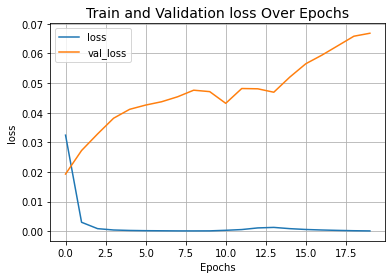

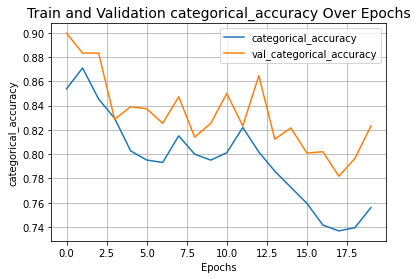

In [41]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
plot_result("loss")
plot_result("categorical_accuracy")

**8. Test the Model**

In [42]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 58ms/step - loss: 0.0641 - categorical_accuracy: 0.8352
Categorical accuracy on the test set: 83.52%.


**9. Inference**

In [43]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

In [44]:
# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

In [45]:
# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'Probabilistic models learned as density estimators can be exploited in\nrepresentation learning beside being toolboxes used to answer inference queries\nonly. However, how to extract useful representations highly depends on the\nparticular model involved. We argue that tractable inference, i.e. inference\nthat can be computed in polynomial time, can enable general schemes to extract\nfeatures from black box models. We plan to investigate how Tractable\nProbabilistic Models (TPMs) can be exploited to generate embeddings by random\nquery evaluations. We devise two experimental designs to assess and compare\ndifferent TPMs as feature extractors in an unsupervised representation learning\nframework. We show some experimental results on standard image datasets by\napplying such a method to Sum-Product Networks and Mixture of Trees as\ntractable models generating embeddings.'
Label(s): ['cs.LG' 'stat.ML' 'cs.AI']
Predicted Label(s): (cs.LG, stat.ML, cs.CV)
 
Abstract: b"The task 

> The prediction results are not that great but not below the par for a simple model like ours. We can improve this performance with models that consider word order like LSTM or even those that use Transformers (Vaswani et al.).